# Overview map with LVM pointing shown

In [1]:
from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.fibers import FiberBundle

In [2]:
pxsize = 2 * u.arcsec
mcels_ha, ha_hdr  = fits.getdata('N44_mcels.ha.scale.fits', header=True)
mcels_sii = fits.getdata('N44_mcels.sii.scale.fits')
mcels_oiii = fits.getdata('N44_mcels.oiii.scale.fits')

obs_data = {6562.81: mcels_ha*0.6, 4861.: mcels_ha*0.6*0.49, 5007.: mcels_oiii, 4959.: mcels_oiii/3.,
            6548.: mcels_ha*0.17, 6584.: mcels_ha*0.22, 6717.: mcels_sii*0.54, 6731.: mcels_sii*0.46}

In [3]:
wcs = WCS(ha_hdr) 
coord = wcs.pixel_to_world([512],[512])  
ra = coord.ra.degree[0]
dec = coord.dec.degree[0]
print('Image center:',ra,dec)
print(coord.to_string('hmsdms'))

Image center: 80.63735604787155 -67.96720064463105
['05h22m32.96545149s -67d58m01.92232067s']


In [4]:
name = 'N44_example1'
fov_size = 35
fov_pixel = 2
my_lvmfield = LVMField(ra, dec, fov_size, fov_pixel, name=name)

In [5]:
my_nebulae = [
        {"type": 'DIG', 'max_brightness': 1e-16 * u.erg / u.cm ** 2 / u.s / u.arcsec ** 2,
         'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc},
        {"type": 'CustomNebula', 'brightness_map': mcels_ha, 'brightness_lines':obs_data,
         'offset_RA': 0, 'offset_DEC': 0, 'pxsize': pxsize}
]
my_lvmfield.add_nebulae(my_nebulae, save_nebulae=name+".fits", overwrite=True)

[INFO]: Start generating 2 nebulae
[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_227'. Its parameters: Geometry = Cloud; Z = 0.8; nH = 100.0; Teff = 40000.0; LogLsun = 6.0; 
[INFO]: Generated ISM saved to ./N44_example1/N44_example1.fits
[INFO]: ISM content saved to N44_example1.fits


[INFO]: Using the full hexagon pattern
[INFO]: 75451 Gaia stars in the field
[INFO]: 75445 stars are fainter than 10 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
[INFO]: Rescaling 6 synthetic spectra.
[INFO]: Saving star list to: ./N44_example1/N44_example1_starlist.fits.gz
[WARNING]: The file ././N44_example1/N44_example1_starlist.fits.gz already exist and it will be overwritten


INFO: Query finished. [astroquery.utils.tap.core]


[WARNING]: Bundle center coords are not defined, using the coords of the field.


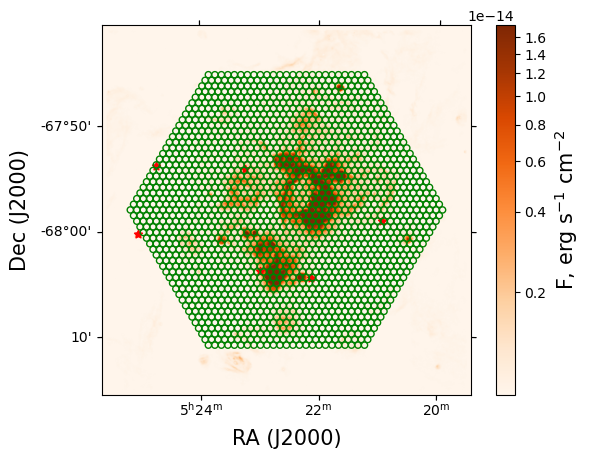

In [6]:
bundle = FiberBundle(bundle_name='full')
my_lvmfield.generate_gaia_stars(gmag_limit=10)
#my_lvmfield.get_map(wavelength_ranges=[6550, 6570])
my_lvmfield.show(fibers=bundle.fibers_science, outname=name+"_fibers.png")

# LVM Data Simulator tutorial: exposure time calculator

**This is a tutorial on how run the simulator to estimate the exposure time needed to reach a signal to noise at a specific wavelength.**
- How to install the simulator and how to prepare a custom simulation is shown in [tutorial #1](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial1.ipynb)
- More details on the setup of LVM instrumentation and on the structure of the outputs of the simulator are given in [tutorial #2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb)
- More realistic and useful simulations are considered in [tutorial #3](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial3.ipynb) - please go there if you have already installed and configured the package and want to learn how to simulate the source field in more details.

_Last update: 2022/09/01_

We assumed lvmdatasimulator has been installed following [tutorial #1](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial1.ipynb). As usual, move this file to an empty directory, or set-up the working directory as follows:

In [7]:
# === Don't forget to set up your work directory (not valid for running on UTAH cluster)
import os
# os.chdir('/Users/mors/Science/LVM/Simulator_example/')

## Setting up the ETC

This simulator can be easily used to estimate the required LVM exposure time to obtain a certain signal-to-noise ratio (S/N) for a simple source configuration. It simulates only the central fiber of the array, and provide plots showing how the S/N changes as a function of exposure time. For complex scenarios, a full simulation should be run following instructions on the other tutorials.

This ETC will simulate only nebulae with:
- uniform brightness distribution
- constant emission line ratios (defined by one of the pre-computed Cloudy models)
- or/and constant level and shape of the continuum.
On top of this a star with particular properties also can be part of the object under evaluation. Nebular component, continuum from the object and the stellar spectrum will be combined together by the simulator in a single fiber, for which we will run the calculations.

**N.B.: the resulting S/N ratio is the value measured per spectral pixel (0.5A) in the output spectra at a particular wavelength. This simplified ETC doesn't integrate the emission lines and do not subtract the underlying continuum but rather estimate the S/N in the pixel at the center of the line.**

**N.B.2: All calculations are performed assuming a single exposure.**

In [8]:
from lvmdatasimulator.run import run_lvm_etc

The first step is to define the parameters of your nebula. The only required parameter is 'max_brightness' (in erg/s/cm\^2/arcsec^2).
See [tutorial #3](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial3.ipynb) if you want to learm how to specify the spectral properties (emission and continuum) of the nebula.

In [9]:
n44_brightness = 7e-15 # based on 1250 R

In [26]:
neb_params = {'max_brightness': n44_brightness, 'model_id': 'Shell_108', 'model_type': 'cloudy'}

Also you may define parameters of the star if you want to put it in the fiber. It should be a dictionary containing the magnitude and temperature of the desired star, as follows:

In [27]:
star_params = {'gmag': [10], 'teff': [10000]}

Other parameters can be passed to the simulator in general (see [tutorial #3](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial3.ipynb)), but only these two should be used when running the ETC. Also note that the parameters must be provided as lists.

The dictionary below (``params``) is the main input for the ETC. It joins together the parameters of the nebula and the star, and also can contain parameters defining the observations (see [tutorial 2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb)). Note that ``exptimes`` is not used as it is hardcoded in the ETC. As a default, the simulation is run at an airmass of 1.5 and in dark conditions (0 days from new moon). These conditions can be adjusted by providing the ``airmass`` and ``days_moon`` parameters in the ``params`` dictionary, as shown below. It is also possible to provide a custoim sky spectrum via the ``sky_template`` parameter, as described in [tutorial 2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb). 

Other three parameters are required to run the ETC:
- ``check_lines`` - list of the lines (wavelength in A, float) for which ETC will check the dependence of the S/N on the exposure time.
- ``desired_snr`` - if provided, then ETC will print (and return) the required exposures to reach the target S/N at the respective wavelength.
- ``continuum`` - bool (default is False). It defines how the S/N ratio will be calculated. If it is true, then the code assumes we are interested in the S/N in the continuum rather then in emission lines - then the S/N per spectral pixel will be considered. Otherwise, the code assumes the measurements in emission lines, and thus the S/N is measured by integrating the signal and estimating the noise in the ±2A aperture around the wavelengths in ``check_lines``.
- ``delete`` - bool (default is True). If this parameter is set to True, all the files produced during the simulations will be deleted. If you want to keep all the output, please set ``delete`` to False.


In [28]:
params = {'name': 'N44',
          'nebula': neb_params,
          'airmass': 1.6,
          'days_moon': 7,
          }

[INFO]: Start simulations in exposure time calculator mode for 1 nebula 
[INFO]: Start generating 1 nebulae
[INFO]: Generated ISM saved to ./N44/test.fits
[INFO]: ISM content saved to test.fits
[INFO]: Using only the central fiber.
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 7 days from new moon.
[INFO]: Using sky file: /Users/tonywong/Library/Python/3.9/lib/python/data/sky/LVM_LVM160_SKY_7.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 1 fibers.
[INFO]: Start extracting nebular spectra
[INFO]: Resampling spectra to the instrument wavelength solution.
[INFO]: Saving the outputs:
[INFO]: Input spectra
[INFO]: ./N44/outputs/N44_linear_central_input.fits saved.
[INFO]: Clean outputs
[INFO]: ./N44/outputs/N44_linear_central_10_no_noise.fits saved.
[INFO]: ./N44/outputs/N44_linear_centra

To reach S/N=300 in line = 6563.0±1A we need 729s of single exposure
To reach S/N=3 in line = 4363±1A we need 11623s of single exposure
To reach S/N=3 in line = 6312±1A we need 418s of single exposure


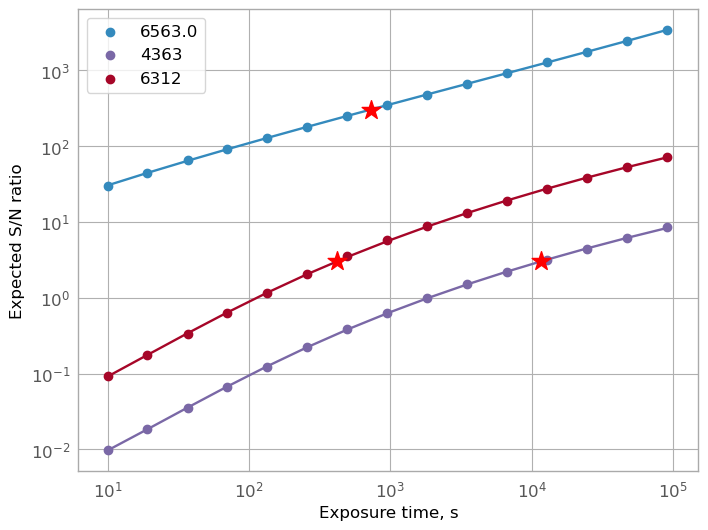


Elapsed time: 3.2s


[729, 11623, 418]

In [42]:
run_lvm_etc(params, check_lines=[6563.,4363,6312], desired_snr=[300,3,3], continuum=False, delete=False)

In [36]:
# params = {'name': 'N44-star',
#           'star': star_params,
#           'airmass': 1.6,
#           'days_moon': 7,
#           }

In [37]:
#run_lvm_etc(params, check_lines=[5000.], desired_snr=[30], continuum=True)

### Warnings

When providing a spectrum, there are a few things to keep in mind:
- The spectrum should be uniformly sampled, and the wavelength array in linear units.
- If the spectrum does not cover the full wavelength range covered by the LVM, it is going to be extended via extrapolation.
- The simulator will convolve and resample the input spectrum during the simulation to produce a final oputput with a sampling off 0.5 aa/pix and an LSF with a FWHM of 1.5 AA. To obtain better results, we suggest to provide spectra with an higher sampling.  

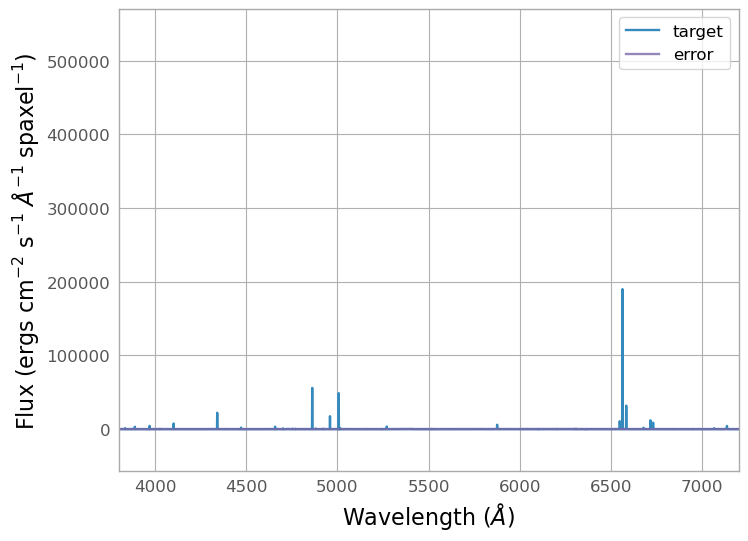

In [38]:
import matplotlib.pyplot as plt
import numpy as np
def plot_spec(xfits='N44/outputs/N44_linear_central_3483_realization.fits',wmin=3800,wmax=7200):
    x=fits.open(xfits)
    w=x['WAVE'].data
    flux=x['TARGET'].data[0]
    total=x['TOTAL'].data[0]
    err=x['ERR'].data[0]
    
    select=[]
    i=0
    while i<len(w):
        if wmin<=w[i] and w[i]<=wmax:
            select.append(i)
        i+=1
    w=w[select]
    flux=flux[select]
    total=total[select]
    err=err[select]
    
    plt.plot(w,flux,label='target')
    # plt.plot(w,total,label='total',alpha=0.8)
    plt.plot(w,err-0.5e-13,label='error',alpha=0.8)
    plt.legend()
    plt.xlim(wmin,wmax)
    ymax=3*np.max(flux)
    ymin=-0.1*ymax
    plt.ylim(ymin,ymax)
    # plt.ylim(-1e-13,3e-13)
    plt.xlabel(r'Wavelength ($\AA$)',size=16)
    plt.ylabel(r'Flux (ergs cm$^{-2}$ s$^{-1}$ $\AA^{-1}$ spaxel$^{-1}$)',size=16)
               
    plt.savefig('snr.png')

plot_spec(wmin=3800,wmax=7200)

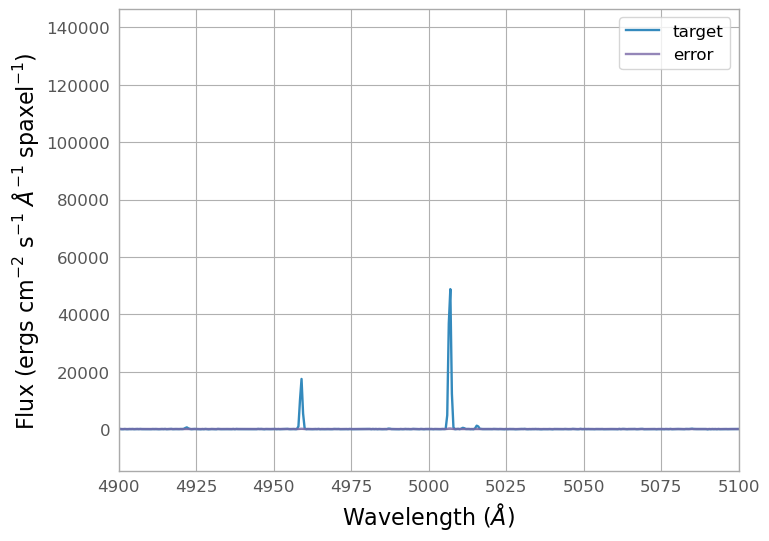

In [39]:
plot_spec(wmin=4900,wmax=5100)

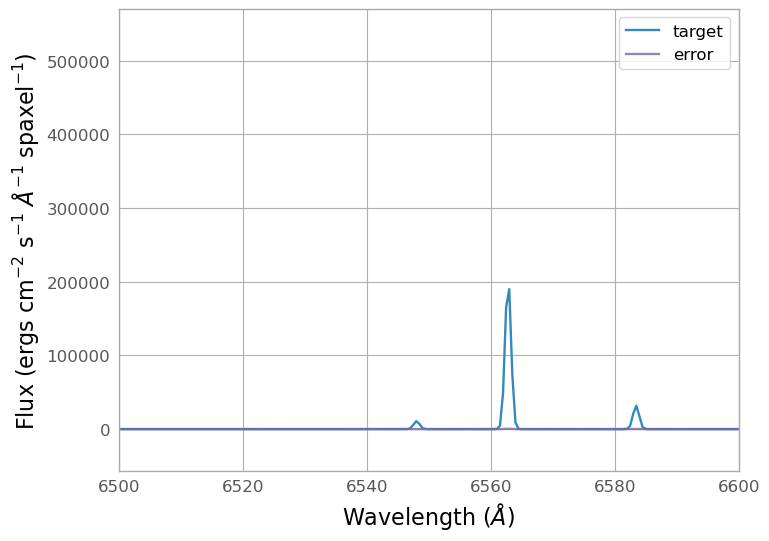

In [40]:
plot_spec(wmin=6500,wmax=6600)